# 1.Setup

## 1.1 Install Dependencies

In [ ]:
!pip install opencv-python matplotlib

## 1.2 Import Dependencies

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Import tensforlow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


## 1.3 Set GPU Growth

In [ ]:
#Avoid OOM errors by setting GPU memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [ ]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
#Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positive and Anchor Classes

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!tar -xf /content/drive/My\ Drive/lfw.tgz

In [ ]:
#Move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [ ]:
#Import uuid to generate unique image names
import uuid

In [ ]:
uuid.uuid1()

UUID('945877d0-7fc3-11ef-81c0-0242ac1c000c')

In [ ]:


import cv2
import numpy as np
import uuid
import os
import base64
from google.colab import output
from IPython.display import display, Javascript

# Define paths for saving images (ensure these directories exist)
ANC_PATH = '/content/data/anchor'  # Set your anchor directory path
POS_PATH = '/content/data/positive'  # Set your positive directory path

# JavaScript to access the webcam and capture images
js_code = '''
let video;
let canvas;
let context;

async function setupCamera() {
    video = document.createElement('video');
    video.width = 250;
    video.height = 250;
    const stream = await navigator.mediaDevices.getUserMedia({
        video: true
    });
    video.srcObject = stream;
    await new Promise((resolve) => {
        video.onloadedmetadata = () => {
            resolve(video);
        };
    });
    video.play();
    document.body.append(video);

    // Create canvas for image capturing
    canvas = document.createElement('canvas');
    canvas.width = 250;
    canvas.height = 250;
    context = canvas.getContext('2d');
    document.body.append(canvas);
}

async function captureImage(anchorType) {
    context.drawImage(video, 0, 0, 250, 250);
    const dataUrl = canvas.toDataURL('image/jpeg');

    // Send image data to Python for saving
    google.colab.kernel.invokeFunction('save_image', [dataUrl, anchorType], {});
}

async function main() {
    await setupCamera();

    // Create buttons for capturing images
    const anchorButton = document.createElement('button');
    anchorButton.textContent = 'Capture Anchor';
    anchorButton.onclick = async () => {
        await captureImage('anchor');  // Automatically captures and saves
    };

    const positiveButton = document.createElement('button');
    positiveButton.textContent = 'Capture Positive';
    positiveButton.onclick = async () => {
        await captureImage('positive');  // Automatically captures and saves
    };

    const stopButton = document.createElement('button');
    stopButton.textContent = 'Stop Capture';
    stopButton.onclick = () => {
        video.pause();
        video.srcObject.getTracks()[0].stop();
        video.remove();
        canvas.remove();
        anchorButton.remove();
        positiveButton.remove();
        stopButton.remove();
    };

    document.body.append(anchorButton);
    document.body.append(positiveButton);
    document.body.append(stopButton);
}

main();
'''

# Function to save images from JavaScript
def save_image(data_url, anchor_type):
    # Decode the base64 image data
    header, encoded = data_url.split(',', 1)
    image_data = np.frombuffer(base64.b64decode(encoded), np.uint8)
    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

    # Define file name and path based on the anchor type
    if anchor_type == 'anchor':
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    else:
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))

    # Save the image
    cv2.imwrite(imgname, image)
    print(f'Saved {anchor_type} image to {imgname}')  # Print confirmation for debugging

# Register the Python function to call from JavaScript
output.register_callback('save_image', save_image)

# Display the JavaScript code
display(Javascript(js_code))


<IPython.core.display.Javascript object>

In [ ]:
import shutil

# Define the path to your folder containing positive images in Google Drive
folder_path = '/content/drive/MyDrive/positive'  # Update this path

# Copy images to the positive directory in Colab
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for common image formats
        shutil.copy(os.path.join(folder_path, filename), '/content/data/positive/')

# Define the path to your folder containing positive images in Google Drive
folder_path = '/content/drive/MyDrive/anchor'  # Update this path

# Copy images to the positive directory in Colab
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for common image formats
        shutil.copy(os.path.join(folder_path, filename), '/content/data/anchor/')



In [ ]:
print( len([file for file in os.listdir('/content/data/anchor')]))
print( len([file for file in os.listdir('/content/data/positive')]))

304
302


# 3. Load and Preproccess Images

## 3.1 Get Image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
dir_test.next()

b'/content/data/anchor/818219bf-7fbf-11ef-9c0e-84a938cc0aeb.jpg'

## 3.2 Preprocessing - Scale and Resize

In [ ]:
def preprocess(file_path):
    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    #Scale image to be between 0 and 1
    img = img / 255.0
    return img


## 3.3 Create Labeled Dataset

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
example = samples.next()

## 3.4 Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(example[0], example[1], example[2])

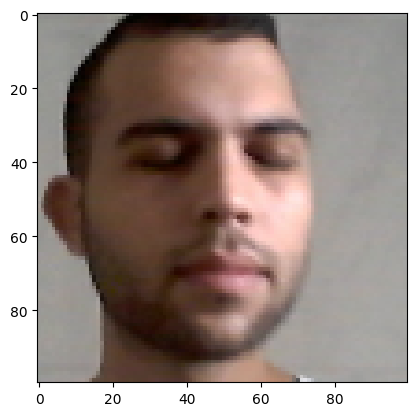

In [ ]:
plt.imshow(res[0])

In [ ]:
#BUild Dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
train_samples = train_data.as_numpy_iterator()

In [ ]:
train_sample = train_samples.next()

In [ ]:
len(train_sample[0])

16

In [ ]:
#Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
#

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [ ]:
def make_embedding():
  inp = Input(shape=(100,100,3), name = 'input_image')

  #1st block
  c1= Conv2D(64,(10,10), activation = 'relu')(inp)
  m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)

  #2nd block
  c2= Conv2D(128,(7,7), activation = 'relu')(m1)
  m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)

  #3rd block
  c3= Conv2D(128,(4,4), activation = 'relu')(m2)
  m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)

  #Final embedding block
  c4= Conv2D(256,(4,4), activation = 'relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation = 'sigmoid')(f1)


  return Model(inputs=[inp] , outputs=[d1] ,name= 'embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [ ]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
      return tf.math.abs(input_embedding[0] - validation_embedding[0])


In [ ]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [ ]:
def make_siamese_model():

  #Handle inputs
  input_image = Input(name='input_img', shape=(100,100,3))
  validation_image = Input(name = 'validation_image', shape=(100,100,3))

  #Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  #Classification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_image          │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_image[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_1 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

##5.2 Establish Checkpoints

In [ ]:
checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

## 5.3 Build Train Step Function

In [ ]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
      #Get anchor and positive//negative image
      X = batch[:2]
      #Get label
      y = batch[2]
      #Forward Pass
      yhat = siamese_model(X,training = True)
      #Calculate loss
      loss = binary_cross_loss(y,yhat)
    print(loss)
    #Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    #Return loss
    return loss




## 5.4 Build Training Loop

In [ ]:
def train(data, EPOCHS):
  #Loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    #Loop through each batch
    for idx, batch in enumerate(data):
    #Run train step here
      train_step(batch)
      progbar.update(idx+1)

    #Save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [ ]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f'Restoring from {latest_checkpoint}')
    checkpoint.restore(latest_checkpoint).expect_partial()
else:
    print('No checkpoint found.')

Restoring from /content/drive/My Drive/training_checkpoints/ckpt-11


In [ ]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step

 E

# 6. Evaluate Model

## 6.1 Import Metrics

In [ ]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictons

In [ ]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
#Make predicitons
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[9.9351257e-01],
       [9.9998713e-01],
       [1.8931074e-08],
       [1.3718596e-06],
       [9.9797791e-01],
       [1.0000000e+00],
       [5.2056259e-07],
       [9.9621993e-01],
       [9.9999964e-01],
       [8.4148070e-07],
       [9.9994683e-01],
       [1.1149059e-05],
       [9.9999499e-01],
       [1.0000000e+00],
       [2.7885918e-09],
       [3.1072206e-03]], dtype=float32)

In [ ]:
#Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]

In [ ]:
y_true

array([1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [ ]:
#Creating a metric object
m =Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return recall result
m.result().numpy()

1.0

In [ ]:
#Creating a metric object
m =Precision()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return recall result
m.result().numpy()

1.0

##6.4 Viz Results

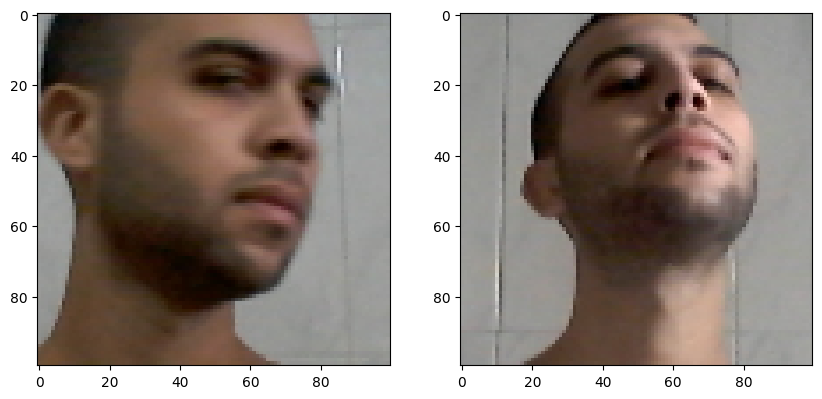

In [ ]:
plt.figure(figsize=(10,8))

#Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

#Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# 7. Save Model

In [ ]:
# Save weights
siamese_model.save('/content/drive/My Drive/Siamesemodel.keras')

In [ ]:
if os.path.isfile('/content/drive/My Drive/Siamesemodel.keras'):
    print("Model saved successfully!")
else:
    print("Model not found.")

Model saved successfully!


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Siamesemodel.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
#Make predictions with reloade model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


array([[9.9351257e-01],
       [9.9998713e-01],
       [1.8931074e-08],
       [1.3718596e-06],
       [9.9797791e-01],
       [1.0000000e+00],
       [5.2056259e-07],
       [9.9621993e-01],
       [9.9999964e-01],
       [8.4148070e-07],
       [9.9994683e-01],
       [1.1149059e-05],
       [9.9999499e-01],
       [1.0000000e+00],
       [2.7885918e-09],
       [3.1072206e-03]], dtype=float32)

In [ ]:
model.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_image          │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_image[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_2 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)